In [1]:
import torch
import numpy as np
import open_clip
from PIL import Image
import matplotlib.pyplot as plt

/opt/conda/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


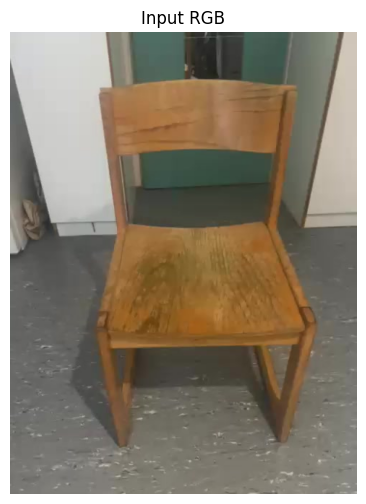

In [2]:
IMAGE_PATH = "chair/image.jpg" 

img_pil = Image.open(IMAGE_PATH).convert("RGB")
plt.figure(figsize=(6,6))
plt.imshow(img_pil)
plt.axis("off")
plt.title("Input RGB")
plt.show()


In [3]:
CLIP_BACKBONE = "ViT-B-16"
CLIP_CHECKPOINT = "datacomp_xl_s13b_b90k"
CLIP_OUTPUT_SIZE = 512

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    CLIP_BACKBONE,
    pretrained=CLIP_CHECKPOINT
)
tokenizer = open_clip.get_tokenizer(CLIP_BACKBONE)

model = model.to(DEVICE).eval()

image = preprocess(img_pil).unsqueeze(0).to(DEVICE)

with torch.no_grad():
    img_feat = model.encode_image(image)                # [1, D]
    print("raw img_feat shape:", tuple(img_feat.shape))
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

print("normalized img_feat shape:", tuple(img_feat.shape))
print("embedding dim:", img_feat.shape[-1])
print("L2 norm:", float(img_feat.norm(dim=-1).cpu()))
print("first 8 dims:", img_feat[0, :8].detach().cpu().numpy())

assert img_feat.shape[-1] == CLIP_OUTPUT_SIZE, f"Expected {CLIP_OUTPUT_SIZE}, got {img_feat.shape[-1]}"


raw img_feat shape: (1, 512)
normalized img_feat shape: (1, 512)
embedding dim: 512
L2 norm: 0.9999999403953552
first 8 dims: [-0.0164209  -0.08397423 -0.02843833  0.02965042  0.06339607 -0.03799039
 -0.06289297 -0.00641592]


In [4]:
texts = [
    "a photo of a chair",
    "a photo of a table",
    "a photo of a sofa",
    "a photo of a car",
    "a close-up photo of wood",
    "a close-up photo of metal",
]

text_tokens = tokenizer(texts).to(DEVICE)

with torch.no_grad():
    txt_feat = model.encode_text(text_tokens)
    txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)

    sims = (img_feat @ txt_feat.T).squeeze(0).detach().cpu().numpy()

pairs = sorted(zip(texts, sims), key=lambda x: x[1], reverse=True)
for t, s in pairs:
    print(f"{s: .4f}  |  {t}")


 0.2876  |  a photo of a chair
 0.2020  |  a photo of a table
 0.1453  |  a photo of a sofa
 0.1448  |  a close-up photo of wood
 0.1254  |  a photo of a car
 0.0967  |  a close-up photo of metal


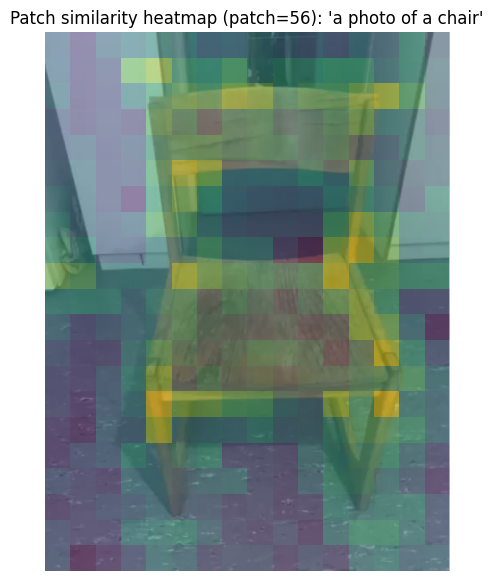

In [5]:
def crop_grid_patches(img_pil, patch_px=56, stride_px=28):
    W, H = img_pil.size
    patches, coords = [], []
    for y in range(0, max(1, H - patch_px + 1), stride_px):
        for x in range(0, max(1, W - patch_px + 1), stride_px):
            patches.append(img_pil.crop((x, y, x + patch_px, y + patch_px)))
            coords.append((x, y))
    return patches, coords, (W, H)

prompt = "a photo of a chair"   # <-- change to "wood", "fabric", etc.
patch_px = 56                   # <-- set to your pipeline's patch_size
stride_px = 28                  # <-- overlap helps

patches, coords, (W, H) = crop_grid_patches(img_pil, patch_px=patch_px, stride_px=stride_px)

with torch.no_grad():
    t = tokenizer([prompt]).to(DEVICE)
    tfeat = model.encode_text(t)
    tfeat = tfeat / tfeat.norm(dim=-1, keepdim=True)

def encode_patches(patches, batch=64):
    feats = []
    with torch.no_grad():
        for i in range(0, len(patches), batch):
            bt = torch.stack([preprocess(p) for p in patches[i:i+batch]], dim=0).to(DEVICE)
            f = model.encode_image(bt)
            f = f / f.norm(dim=-1, keepdim=True)
            feats.append(f)
    return torch.cat(feats, dim=0)

patch_feats = encode_patches(patches, batch=64)

with torch.no_grad():
    patch_sims = (patch_feats @ tfeat.T).squeeze(1).detach().cpu().numpy()

# build heatmap grid
xs = sorted(set([c[0] for c in coords]))
ys = sorted(set([c[1] for c in coords]))
grid = np.zeros((len(ys), len(xs)), dtype=np.float32)

idx = {(x, y): k for k, (x, y) in enumerate(coords)}
for iy, y in enumerate(ys):
    for ix, x in enumerate(xs):
        grid[iy, ix] = patch_sims[idx[(x, y)]]

grid_norm = (grid - grid.min()) / (grid.max() - grid.min() + 1e-8)

plt.figure(figsize=(7,7))
plt.imshow(img_pil)
plt.imshow(grid_norm, extent=[0, W, H, 0], alpha=0.45)
plt.axis("off")
plt.title(f"Patch similarity heatmap (patch={patch_px}): '{prompt}'")
plt.show()


In [6]:
texts = [
    "wood",
    "metal",
    "steel",
    "plastic",
    "fabric",
    "leather",
    "glass",
]


text_tokens = tokenizer(texts).to(DEVICE)

with torch.no_grad():
    txt_feat = model.encode_text(text_tokens)
    txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)

    sims = (img_feat @ txt_feat.T).squeeze(0).detach().cpu().numpy()

pairs = sorted(zip(texts, sims), key=lambda x: x[1], reverse=True)
for t, s in pairs:
    print(f"{s: .4f}  |  {t}")


 0.1995  |  wood
 0.1564  |  metal
 0.1395  |  plastic
 0.1335  |  glass
 0.1315  |  steel
 0.1263  |  leather
 0.1165  |  fabric


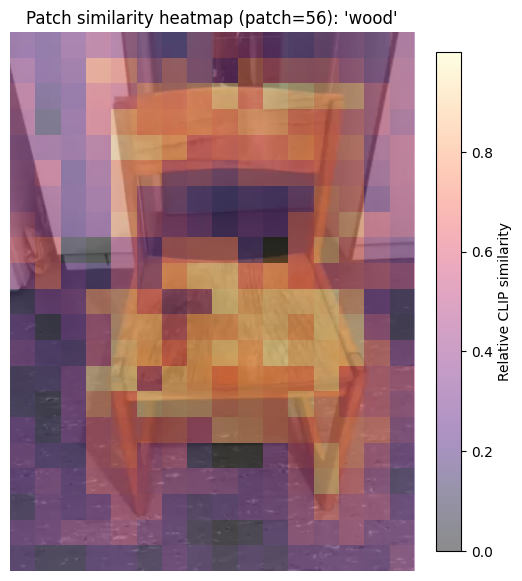

In [ ]:
def crop_grid_patches(img_pil, patch_px=56, stride_px=28):
    W, H = img_pil.size
    patches, coords = [], []
    for y in range(0, max(1, H - patch_px + 1), stride_px):
        for x in range(0, max(1, W - patch_px + 1), stride_px):
            patches.append(img_pil.crop((x, y, x + patch_px, y + patch_px)))
            coords.append((x, y))
    return patches, coords, (W, H)

prompt = "wood"  
patch_px = 56                  
stride_px = 28                 

patches, coords, (W, H) = crop_grid_patches(img_pil, patch_px=patch_px, stride_px=stride_px)

with torch.no_grad():
    t = tokenizer([prompt]).to(DEVICE)
    tfeat = model.encode_text(t)
    tfeat = tfeat / tfeat.norm(dim=-1, keepdim=True)

def encode_patches(patches, batch=64):
    feats = []
    with torch.no_grad():
        for i in range(0, len(patches), batch):
            bt = torch.stack([preprocess(p) for p in patches[i:i+batch]], dim=0).to(DEVICE)
            f = model.encode_image(bt)
            f = f / f.norm(dim=-1, keepdim=True)
            feats.append(f)
    return torch.cat(feats, dim=0)

patch_feats = encode_patches(patches, batch=64)

with torch.no_grad():
    patch_sims = (patch_feats @ tfeat.T).squeeze(1).detach().cpu().numpy()

# build heatmap grid
xs = sorted(set([c[0] for c in coords]))
ys = sorted(set([c[1] for c in coords]))
grid = np.zeros((len(ys), len(xs)), dtype=np.float32)

idx = {(x, y): k for k, (x, y) in enumerate(coords)}
for iy, y in enumerate(ys):
    for ix, x in enumerate(xs):
        grid[iy, ix] = patch_sims[idx[(x, y)]]

grid_norm = (grid - grid.min()) / (grid.max() - grid.min() + 1e-8)

plt.figure(figsize=(7,7))
plt.imshow(img_pil)

hm = plt.imshow(
    grid_norm,
    extent=[0, W, H, 0],
    alpha=0.45,
    cmap="magma"
)

cbar = plt.colorbar(hm, fraction=0.046, pad=0.04)
cbar.set_label("Relative CLIP similarity", rotation=90)

plt.axis("off")
plt.title(f"Patch similarity heatmap (patch={patch_px}): '{prompt}'")
plt.show()


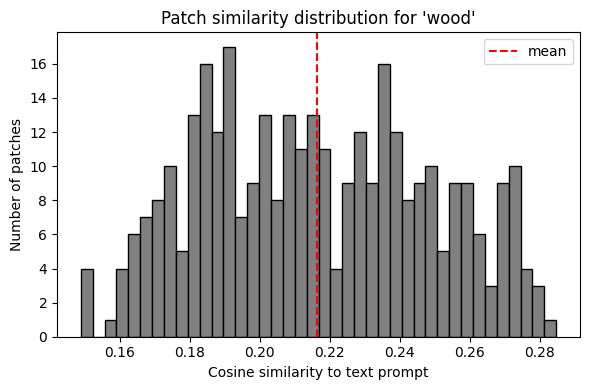

In [8]:
plt.figure(figsize=(6,4))
plt.hist(patch_sims, bins=40, color="gray", edgecolor="black")
plt.axvline(patch_sims.mean(), color="red", linestyle="--", label="mean")
plt.xlabel("Cosine similarity to text prompt")
plt.ylabel("Number of patches")
plt.title(f"Patch similarity distribution for '{prompt}'")
plt.legend()
plt.tight_layout()
plt.show()


## Clip Feature test on 3D point cloud

In [ ]:
PT_PATH = "clip_outputs/clip_features.pt"  

data = torch.load(PT_PATH, map_location="cpu")

# Try common layouts
if torch.is_tensor(data):
    clip_feats = data
elif isinstance(data, dict):
    for k in ["clip_features", "clip_feat", "clip", "features", "feats"]:
        if k in data and torch.is_tensor(data[k]):
            clip_feats = data[k]
            print("Using key:", k)
            break
    else:
        # fallback: pick the first tensor that looks like Nx512
        cand = []
        for k, v in data.items():
            if torch.is_tensor(v) and v.ndim == 2:
                cand.append((k, v.shape))
        raise KeyError(f"Couldn't find clip features. Tensor candidates: {cand}")
else:
    raise TypeError(f"Unsupported .pt content type: {type(data)}")

print("Loaded clip_feats shape:", tuple(clip_feats.shape))


/tmp/ipykernel_1831553/612151587.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(PT_PATH, map_location="cpu")


Loaded clip_feats shape: (284544, 512)


In [ ]:

CLIP_BACKBONE = "ViT-B-16"
CLIP_CHECKPOINT = "datacomp_xl_s13b_b90k"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model, _, _ = open_clip.create_model_and_transforms(CLIP_BACKBONE, pretrained=CLIP_CHECKPOINT)
tokenizer = open_clip.get_tokenizer(CLIP_BACKBONE)
model = model.to(DEVICE).eval()


In [13]:
texts = ["wood", "metal", "steel", "plastic", "fabric", "leather", "glass"]


In [14]:
# Move features to device and normalize
clip_feats = clip_feats.to(DEVICE).float()
clip_feats = clip_feats / (clip_feats.norm(dim=-1, keepdim=True) + 1e-8)

with torch.no_grad():
    t = tokenizer(texts).to(DEVICE)
    text_feats = model.encode_text(t).float()
    text_feats = text_feats / (text_feats.norm(dim=-1, keepdim=True) + 1e-8)

    # sims: [N, T]
    sims = clip_feats @ text_feats.T

print("sims shape:", tuple(sims.shape))  # (N, len(texts))


sims shape: (284544, 7)


In [15]:
sims_cpu = sims.detach().cpu().numpy()
winner = sims_cpu.argmax(axis=1)  # [N]
counts = np.bincount(winner, minlength=len(texts))

print("Winner counts:")
for i, name in enumerate(texts):
    print(f"{name:>8}: {counts[i]}")


Winner counts:
    wood: 266909
   metal: 1702
   steel: 0
 plastic: 11
  fabric: 5781
 leather: 7648
   glass: 2493


In [16]:
prompt = "wood"
k = 20
j = texts.index(prompt)

vals = sims[:, j]
topk_vals, topk_idx = torch.topk(vals, k=k)

print(f"Top-{k} points for '{prompt}':")
for v, idx in zip(topk_vals.detach().cpu().tolist(), topk_idx.detach().cpu().tolist()):
    print(f"idx={idx:>8}  sim={v: .4f}")


Top-20 points for 'wood':
idx=  259096  sim= 0.3038
idx=  259132  sim= 0.3038
idx=  259120  sim= 0.3038
idx=  258799  sim= 0.3038
idx=  258785  sim= 0.3038
idx=  258786  sim= 0.3038
idx=  258790  sim= 0.3038
idx=  258796  sim= 0.3038
idx=  258813  sim= 0.3038
idx=  258811  sim= 0.3038
idx=  258805  sim= 0.3038
idx=  258810  sim= 0.3038
idx=  259064  sim= 0.3038
idx=  259058  sim= 0.3038
idx=  259088  sim= 0.3038
idx=  259090  sim= 0.3038
idx=  258800  sim= 0.3038
idx=  239705  sim= 0.3035
idx=  239738  sim= 0.3035
idx=  239706  sim= 0.3017
